<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/APS_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart: NOAA GEFS forecast, 35 day - dynamical.org zarr
Este recurso ofrece una introducción rápida al conjunto de datos del modelo de pronóstico NOAA GEFS (Global Ensemble Forecast System) con horizonte de 35 días, el cual ha sido transformado por Dynamical.org a un formato listo para análisis y optimizado para la nube utilizando Zarr.

*El conjunto de datos incluye variables meteorológicas y climáticas clave, en una estructura que permite:

*Acceso rápido y eficiente desde plataformas en la nube.

*Procesamiento paralelo y en tiempo real para aplicaciones de ciencia de datos, inteligencia artificial o visualización.

*Exploración del pronóstico extendido (S2S: subseasonal to seasonal) con múltiples miembros del ensamble.

🔗 Documentación completa del conjunto de datos:
https://dynamical.org/catalog/noaa-gefs-forecast-35-day/



In [1]:
# Install dependencies required for this example.
# If you're not using pip to install depdencies (for example, you're using conda or uv),
# skip this cell and and install using the package manager of your choice.
# Restart the notebook after installing dependencies.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy
!pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... D

Usando init_time: 2025-06-24


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


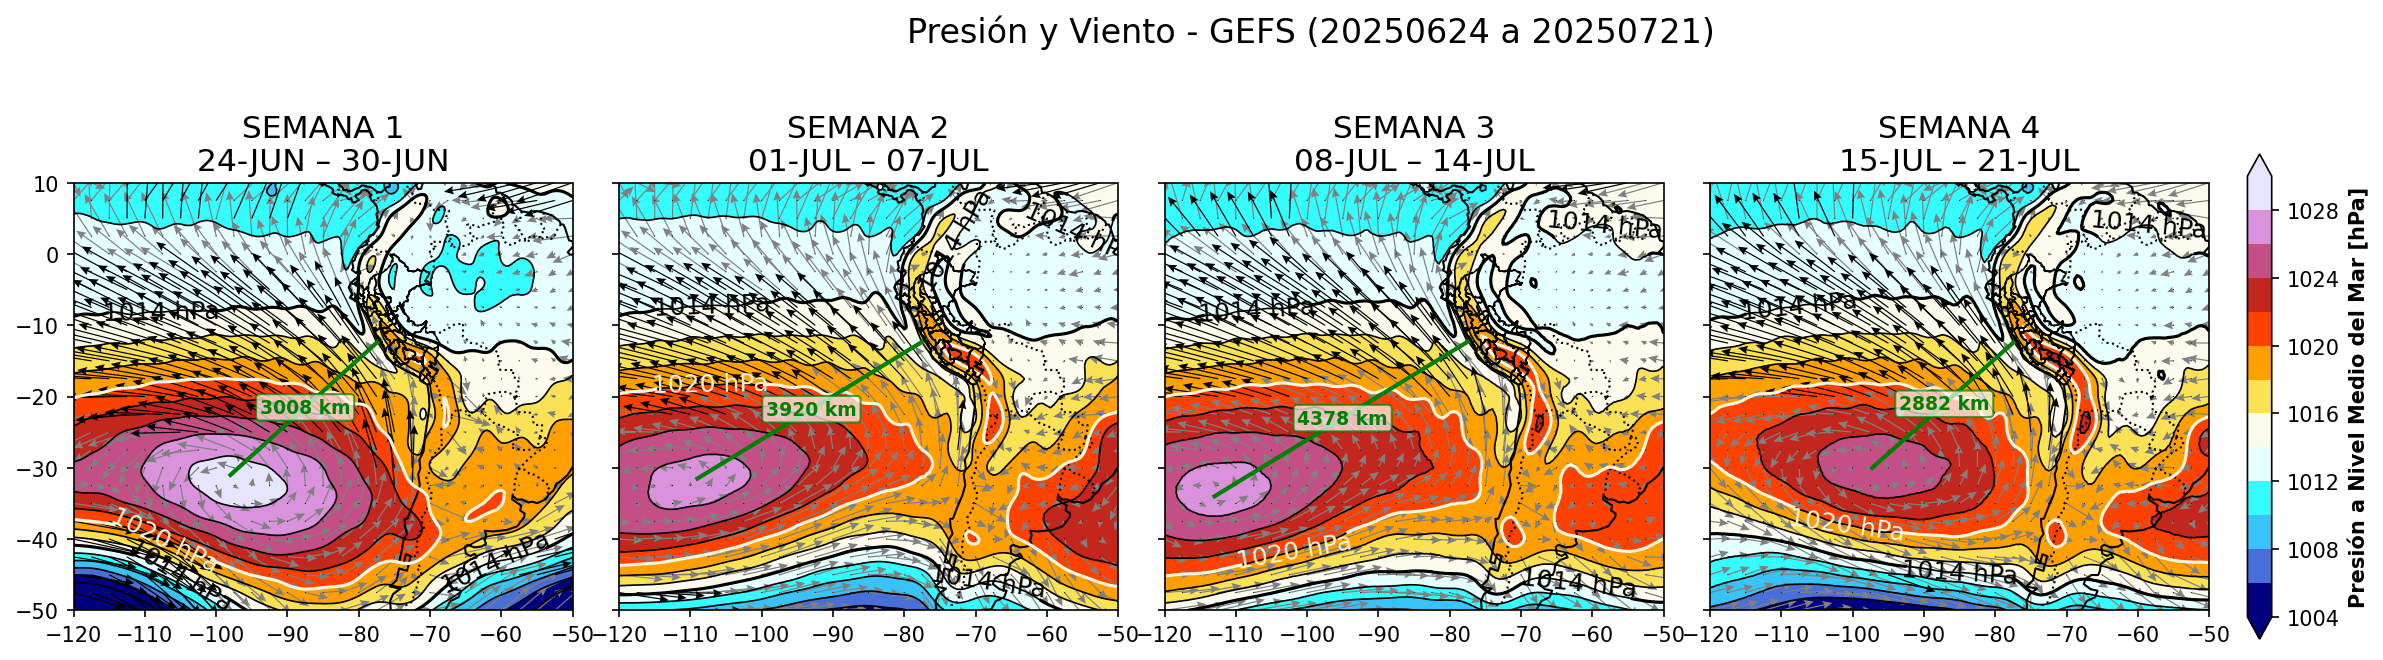

Imagen guardada como: ASP_presion_viento_20250624_20250721_init20250624.png


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import pandas as pd
import tempfile
import requests
import os
from geopy.distance import geodesic

# 1. Descargar shapefile de Perú
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shx",
}

tempdir = tempfile.mkdtemp()
for filename, url in shapefiles.items():
    response = requests.get(url)
    with open(os.path.join(tempdir, filename), "wb") as f:
        f.write(response.content)

gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))

# 2. Abrir dataset GEFS
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init).strftime("%Y-%m-%d"))

# 3. Subset de región (Sudamérica desde el Pacífico)
ds_sub = ds.sel(init_time=latest_init).sel(latitude=slice(10, -50), longitude=slice(-120, -50))
ds_members = ds_sub.sel(lead_time=slice("0h", "27d"))

pressure_all = ds_members["pressure_reduced_to_mean_sea_level"] / 100  # de Pa a hPa
u10_all = ds_members["wind_u_10m"]
v10_all = ds_members["wind_v_10m"]

# 4. Ajuste de tiempo
forecast_time = ds_members.init_time + ds_members.lead_time
pressure_all = pressure_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
u10_all = u10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
v10_all = v10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# 5. Agrupar diario
pressure_daily_all = pressure_all.groupby("forecast_time.date").mean(dim="forecast_time")
u10_daily_all = u10_all.groupby("forecast_time.date").mean(dim="forecast_time")
v10_daily_all = v10_all.groupby("forecast_time.date").mean(dim="forecast_time")

# 6. Definir semanas
semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

# 7. Promedio ensemble
pressure_prom = pressure_daily_all.mean(dim="ensemble_member")
u10_prom = u10_daily_all.mean(dim="ensemble_member")
v10_prom = v10_daily_all.mean(dim="ensemble_member")

# 8. Configuración visual
extent = [-120, -50, -50, 10]
x_ticks = range(-120, -49, 10)
y_ticks = range(-50, 11, 10)

# Colores para MSLP
colors = ["#01007E", "#486ED7", "#39C3F8", "#35FCFF", "#E6FFFF",
          "#FBFCEE", "#F6F6DE", "#FAE156", "#FFA000", "#FC4100",
          "#C3261D", "#C34F86", "#DA92DD", "#E7E5FD"]
cmap_custom = mcolors.ListedColormap(colors)
contour_levels = np.arange(1004, 1032, 2)

# 9. Graficar
fig, axes = plt.subplots(1, 4, figsize=(22, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
fig.subplots_adjust(wspace=0.093, hspace=0)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    pres_avg = pressure_prom.isel(date=rango).mean(dim="date")
    u10_avg = u10_prom.isel(date=rango).mean(dim="date")
    v10_avg = v10_prom.isel(date=rango).mean(dim="date")

    lon, lat = np.meshgrid(pres_avg.longitude.values, pres_avg.latitude.values)
    uwnd_values = u10_avg.values
    vwnd_values = v10_avg.values
    mslp_values = pres_avg.values

    # Calcular magnitud viento
    wind_magnitude = np.sqrt(uwnd_values**2 + vwnd_values**2)
    mask_black = wind_magnitude > 7
    mask_gray = ~mask_black

    # Configuración del mapa
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelbottom=True, labelleft=(i == 0))
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

    # MSLP - colores y contornos
    cmap_mslp = ax.contourf(lon, lat, mslp_values, levels=contour_levels, cmap=cmap_custom, extend='both')
    contours = ax.contour(lon, lat, mslp_values, levels=contour_levels, colors='black', linewidths=0.8)
    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1020], colors='#F6F6DC', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='#F6F6DC')
    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1014], colors='black', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='black')

    # Dibujar viento
    skip = (slice(None, None, 10), slice(None, None, 10))
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_gray[skip], vwnd_values[skip] * mask_gray[skip],
              color='#808080', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_black[skip], vwnd_values[skip] * mask_black[skip],
              color='black', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)

    # Límite Perú
    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, zorder=10)

    # Punto de presión máxima
    idx_max = np.unravel_index(np.argmax(mslp_values, axis=None), mslp_values.shape)
    lat_max = lat[idx_max]
    lon_max = lon[idx_max]

    # Punto de Lima
    lat_lima, lon_lima = -12.05, -77.04

    # Línea verde
    ax.plot([lon_max, lon_lima], [lat_max, lat_lima], color='green', linewidth=2, transform=ccrs.PlateCarree())

    # Distancia
    distancia_km = geodesic((lat_max, lon_max), (lat_lima, lon_lima)).kilometers
    lat_text = (lat_max + lat_lima) / 2
    lon_text = (lon_max + lon_lima) / 2
    ax.text(lon_text, lat_text, f"{distancia_km:.0f} km", fontsize=9, color='green',
            weight='bold', transform=ccrs.PlateCarree(), ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="green", alpha=0.7))

    # Título
    week_dates = pressure_prom.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b").upper()
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b").upper()
    ax.set_title(f"{semana}\n{start_date} – {end_date}", fontsize=15)

# 10. Barra de color
cbar = fig.colorbar(cmap_mslp, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.015)
cbar.set_label("Presión a Nivel Medio del Mar [hPa]", fontsize=10, weight='bold')

# 11. Guardar imagen
start_forecast = pd.to_datetime(str(pressure_prom.date.values[0])).strftime("%Y%m%d")
end_forecast = pd.to_datetime(str(pressure_prom.date.values[-1])).strftime("%Y%m%d")
output_file = f"ASP_presion_viento_{start_forecast}_{end_forecast}_init{pd.to_datetime(latest_init).strftime('%Y%m%d')}.png"
plt.suptitle(f"Presión y Viento - GEFS ({start_forecast} a {end_forecast})", fontsize=16, y=0.92)
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"Imagen guardada como: {output_file}")
